In [1]:
import pickle
import json
import torch

import pandas as pd
from tqdm import tqdm
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Ridge

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask
from s4hci.utils.adi_tools import combine_residual_stack

## Load some data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG")

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
X_train = science_data[0::2]
anlges_train = raw_angles[0::2]
X_test = science_data[1::2]
anlges_test = raw_angles[1::2]

## Find the radial positions

In [4]:
from s4hci.utils.positions import get_validation_positions

In [5]:
test_image = np.mean(X_train, axis=0)
test_separation = 20

In [6]:
positions = get_validation_positions(
    separation=test_separation,
    test_image=test_image,
    num_positions=10)

(0.0, 106.0)

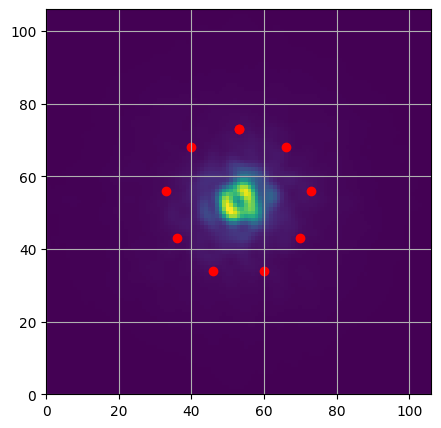

In [7]:
plt.figure(figsize=(5,5))
    
plt.scatter(positions[:, 1], positions[:, 0], color="r")

plt.grid()
plt.imshow(test_image, origin="lower")
plt.xlim(0, 106)
plt.ylim(0, 106)

## Run validation with S4Ridge

In [8]:
from s4hci.models.noise import S4Ridge

In [9]:
lambdas = np.logspace(1, 8, 200)

In [18]:
num_separations = 6

In [10]:
s4_noise_model = S4Ridge(
    psf_template=psf_template_data,
    lambda_reg=None,
    cut_radius_psf=4.0,
    mask_template_setup=("radius", 4.5),
    convolve=True,
    use_normalization=True,
    verbose=True,
    available_devices=[0,],
    half_precision=False)

In [12]:
results, best_lambda = s4_noise_model.validate_lambdas(
    num_separations=num_separations,
    lambdas=lambdas,
    science_data_train=X_train,
    science_data_test=X_test,
    num_test_positions=10,
    approx_svd=5000)

Compute validation positions for separation 17.666666666666668 ...
Setup training data for separation 17.666666666666668 ...
Creating right reason mask ... [DONE]
Build normalization frames ... [DONE]
Compute betas for separation 17.666666666666668 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.29s/it]


Re-mask betas for separation 17.666666666666668 ...
Compute validation errors for separation 17.666666666666668 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.82it/s]


Compute validation positions for separation 35.333333333333336 ...
Setup training data for separation 35.333333333333336 ...
Creating right reason mask ... [DONE]
Build normalization frames ... [DONE]
Compute betas for separation 35.333333333333336 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.08s/it]


Re-mask betas for separation 35.333333333333336 ...
Compute validation errors for separation 35.333333333333336 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.19it/s]


Recommended Lambda = 80264.34
Make sure to check if the tested range of lambda values is covering the global minimum!


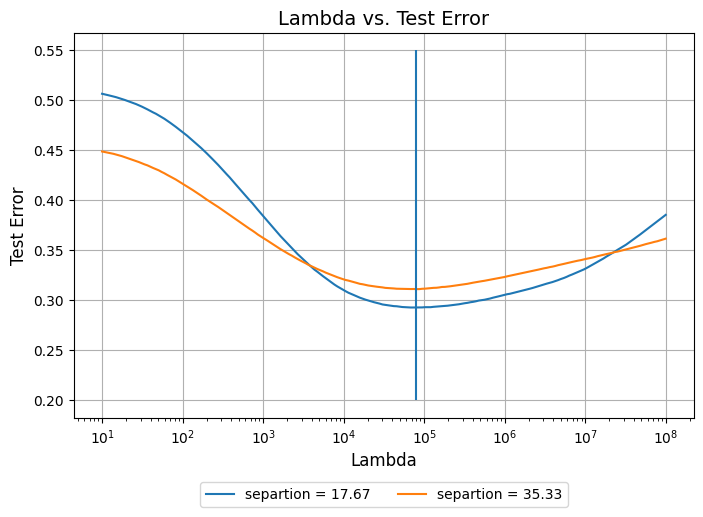

In [17]:
plt.figure(figsize=(8, 5))

for key, tmp_result in results.items():
    plt.plot(lambdas, 
             tmp_result, 
             label="separtion = {:.2f}".format(key))
    
plt.vlines(best_lambda, 0.2, 0.55)

plt.xscale("log")
plt.xlabel("Lambda", size=12)
plt.ylabel("Test Error", size=12)
plt.title("Lambda vs. Test Error", size=14)
plt.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.25))
plt.grid()
plt.savefig("./result_plots/02_validation_error_mask_" + str(4.5) + ".pdf")

## Loop over different mask sizes

In [ ]:
for tmp_mask_size in [4.5, 5.5, 6.5, 8.0]:
    s4_noise_model = S4Ridge(
        psf_template=psf_template_data,
        lambda_reg=None,
        cut_radius_psf=4.0,
        mask_template_setup=("radius", tmp_mask_size),
        convolve=True,
        use_normalization=True,
        verbose=True,
        available_devices=[0,],
        half_precision=False)
    
    tmp_results, tmp_best_lambda = s4_noise_model.validate_lambdas(
        num_separations=num_separations,
        lambdas=lambdas,
        science_data_train=X_train,
        science_data_test=X_test,
        num_test_positions=10,
        approx_svd=5000)
    
    # Create the Plot
    plt.figure(figsize=(8, 5))

    for key, tmp_result in results.items():
        plt.plot(lambdas, 
                 tmp_result, 
                 label="separtion = {:.2f}".format(key))

    plt.vlines(best_lambda, 0.2, 0.55)

    plt.xscale("log")
    plt.xlabel("Lambda", size=12)
    plt.ylabel("Test Error", size=12)
    plt.title("Lambda vs. Test Error", size=14)
    plt.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.25))
    plt.grid()
    plt.savefig("./result_plots/02_validation_error_mask_" + str(tmp_mask_size) + ".pdf")

Compute validation positions for separation 7.571428571428571 ...
Setup training data for separation 7.571428571428571 ...
Creating right reason mask ... [DONE]
Build normalization frames ... [DONE]
Compute betas for separation 7.571428571428571 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.09s/it]


Re-mask betas for separation 7.571428571428571 ...
Compute validation errors for separation 7.571428571428571 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.39it/s]


Compute validation positions for separation 15.142857142857142 ...
Setup training data for separation 15.142857142857142 ...
Creating right reason mask ... [DONE]
Build normalization frames ... [DONE]
Compute betas for separation 15.142857142857142 ...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7/10 [00:57<00:23,  7.87s/it]

## Old code from the implementation

In [11]:
s4_noise_model = S4Ridge(
    psf_template=psf_template_data,
    lambda_reg=None,
    cut_radius_psf=4.0,
    mask_template_setup=("radius", 4.5),
    convolve=True,
    use_normalization=True,
    verbose=True,
    available_devices=[0,],
    half_precision=False)

In [12]:
# normalize the data
s4_noise_model._setup_training(X_train)
s4_noise_model.science_data_norm = s4_noise_model.normalize_data(X_train)

Creating right reason mask ... [DONE]
Build normalization frames ... [DONE]


In [13]:
# collect all parameters for the SVD
X_torch = torch.from_numpy(s4_noise_model.science_data_norm).unsqueeze(1)
M_torch = torch.from_numpy(s4_noise_model.right_reason_mask)

if s4_noise_model.convolve:
    p_torch = torch.from_numpy(
        s4_noise_model.template_norm).unsqueeze(0).unsqueeze(0)
else:
    p_torch = None

In [14]:
positions = np.round(np.dstack(pol2cart(
    30, 
    angles))[0]).astype(int)

positions += image_size_radius 

In [15]:
lambdas = np.logspace(1, 8, 200)

In [16]:
betas_conv = compute_betas_svd(
    X_torch=X_torch,
    M_torch=M_torch,
    lambda_regs=np.logspace(1, 8, 200),
    positions=positions,
    p_torch=p_torch,
    rank=0,
    approx_svd=5000,
    half_precision=s4_noise_model.half_precision,
    verbose=s4_noise_model.verbose)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.19s/it]


In [17]:
betas_conv.shape

torch.Size([10, 200, 107, 107])

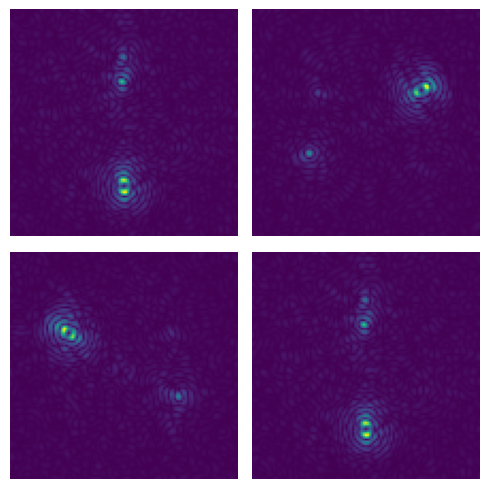

In [18]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))

ax1.imshow(torch.abs(betas_conv[0, 80]))
ax1.set_axis_off()
ax2.imshow(torch.abs(betas_conv[3, 80]))
ax2.set_axis_off()
ax3.imshow(torch.abs(betas_conv[6, 80]))
ax3.set_axis_off()
ax4.imshow(torch.abs(betas_conv[9, 80]))
ax4.set_axis_off()

plt.tight_layout()

In [19]:
# compute the re-mask
second_mask = construct_rfrr_mask(
    template_setup=('radius', s4_noise_model.cut_radius_psf),
    psf_template_in=s4_noise_model.template_norm,
    mask_size_in=s4_noise_model.image_size,
    use_template=True)

In [20]:
re_masked = torch.zeros_like(betas_conv)
all_idx = []
for i, tmp_position in enumerate(positions):
    x, y = tmp_position
    tmp_idx = x * s4_noise_model.image_size + y
    all_idx.append(tmp_idx)
    
    re_masked[i] = betas_conv[i] * second_mask[tmp_idx]

In [21]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6))

ax1.imshow(torch.abs(re_masked[0, 0]))
ax1.set_axis_off()
ax1.set_title("Re-masked")
ax2.imshow(torch.abs(betas_conv[0, 0]))
ax2.set_axis_off()
ax2.set_title("Not Re-mased")
ax3.imshow(torch.abs(re_masked[5, 0]))
ax3.set_axis_off()
ax4.imshow(torch.abs(betas_conv[5, 0]))
ax4.set_axis_off()

plt.tight_layout()

In [22]:
# Run a prediction for the given positions
re_masked.shape

In [23]:
science_test = torch.from_numpy(X_test)
science_test = s4_noise_model.normalize_data(science_test)

In [24]:
science_test = science_test.view(science_test.shape[0], -1)
gt_values = science_test[:, all_idx]

median_errors = []

for tmp_lambda_idx in tqdm(range(re_masked.shape[1])):
    
    tmp_beta = re_masked[:, tmp_lambda_idx]
    tmp_beta = tmp_beta.view(tmp_beta.shape[0], -1)
    
    tmp_prediction = science_test @ tmp_beta.T
    tmp_residual = torch.abs(gt_values - tmp_prediction)
    
    tmp_median_error = torch.median(tmp_residual)
    median_errors.append(tmp_median_error)

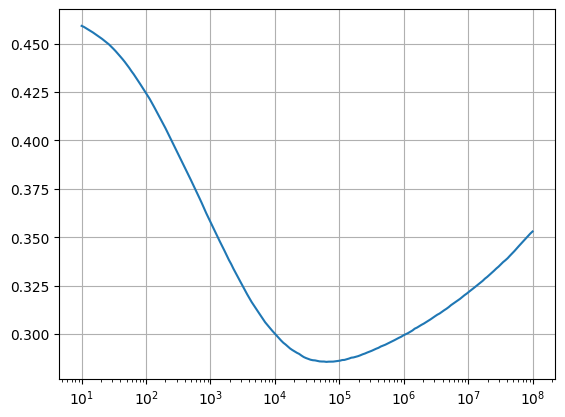

In [27]:
plt.plot(lambdas, np.array(median_errors))
plt.xscale("log")
plt.grid()